In [6]:
import numpy as np

def CBS(row):
    """consolidated bid size"""
    col = row.copy()
    col[col >= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]

def CAS(row):
    """consolidated ask size"""
    col = row.copy()
    col[col <= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]

def TCBS(row):
    """total consolidated bid size"""
    cbs = CBS(row)
    return np.sum(cbs)

def TCAS(row):
    """total consolidated ask size"""
    cbs = CAS(row)
    return np.sum(cbs)

def WBP(row):
    """weighted bid price"""
    cbs = CBS(row)
    tcbs = np.sum(cbs)
    wbp = 0
    for p, cbsi in enumerate(cbs):
        wbp += (p+1) * (cbsi / tcbs)
    return wbp

def WAP(row):
    """weighted bid price"""
    cas = CAS(row)
    tcas = np.sum(cas)
    wbp = 0
    for p, casi in enumerate(cas):
        wbp += (p+1) * (casi / tcas)
    return wbp

def AWS(row):
    """actvity weighted spread"""
    return WAP(row) - WBP(row)

def AP(tapes_segment):
    """average price"""
    pass

def AWR(tapes):
    """activity weighted return"""
    pass

In [11]:
from scipy.sparse import load_npz

# Load the sparse matrix from the "test.npz" file
loaded_array = load_npz("CSR_Data\CSR_LOB_2025-01-02.npz")

dense_array = loaded_array.toarray()

In [12]:
cbs = np.apply_along_axis(CBS, axis=0, arr=dense_array)
cas = np.apply_along_axis(CAS, axis=0, arr=dense_array)

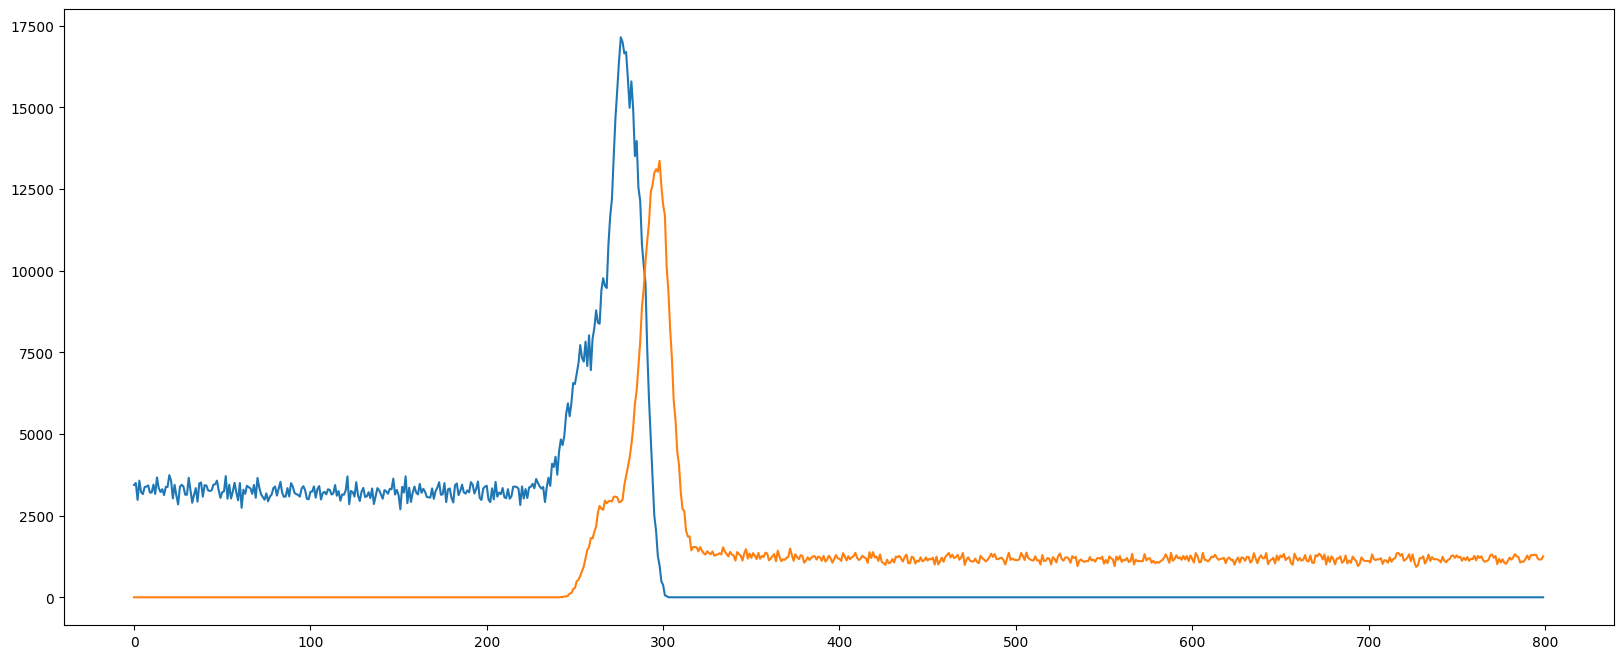

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(cbs)
plt.plot(cas)